## Key steps:
### 1. Convert a user's question into a TRAPI json using a query template (LLM facilitated)
### 2. Validate the TRAPI json format
### 3. Refine the TRAPI json format by selecting the similar categories and predicates  (LLM facilitated) and user's selection
### 4. ID formating
### 5. Query, rank, and visualization


![image.png](../Figures/LLM_TRAPI_converting2.png)



In [3]:
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:

import openai
import json
import ipywidgets as widgets
from IPython.display import display


confi = json.loads(open("/Users/guangrong/Documents/confidential/openAPI_key.json").read()) # replace with your api key
openai.organization = confi['Organization']
openai.api_key = confi['API_key']



In [7]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
#print(APInames.keys())

# Step 2: Get metaKG from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))

KG_category = list(set( list(metaKG['Subject'].unique()) + list(metaKG['Object'].unique())))
KG_predicates = list(metaKG['KG_category'].unique())


metaKG_triplets = metaKG[['Subject', 'KG_category', 'Object']]
metaKG_triplets_dic = metaKG_triplets.to_dict('records')

# Step 3: Load the query template
query_json_temp = TCT.load_json_template()
query_json = str(query_json_temp)
print(query_json)


69
{'message': {'query_graph': {'nodes': {'n0': {'ids': [], 'categories': ['biolink:category']}, 'n1': {'categories': ['biolink:category']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:predicates']}}}}}


In [8]:
def convert_Question2Query(question):
    # formatting query text
    input_text = "We know the avaiable predicates in the KG are: " + ','.join(list(set(KG_predicates))) + ". We also know the avaiable categories in the KGs are "+ ','.join(list(set(KG_category))) +". We also know a TRAPI message temple is " +query_json+ ". With the question of " + question + " What is the json format of message to represent this question? The following rules for the output: 1) The result must be just a json format with the same structure with template; 2)categories should be replaced from the categories in the KG; 3)predicts can be replaced from the predicates in the KG; 4) can use the name to fill the ids; 4)the output must start with '{' and end with '}', and be a standard json format.  At least one ids should be given and No annotations are needed!"
    query_json_cur = TCT.ask_chatGPT4(input_text)
    query_json_cur_clean = TCT.extract_json(query_json_cur)
    return query_json_cur_clean

In [9]:
# Example questions
question = "What genes or proteins interact with KRAS?"  #successful running
#question2 = "What drugs may treat Type 2 diabetes?" #successful running
#question3 = "what disease we can consider to treat with drug Olaparib?" #successful running
#question4 = "What could be potential targets for ovarian cancer?" 
#question5 = "What are the drugs or small moleculaes that target the gene KRAS?" #successful running
#question6 = "What diseases co-occurence with covid-19?"  #successful running
#question7 = "What symptoms are associated with long covid?" # no results
#question8 = "What genes are associated with aptosis?"  # successful running
#question9 = "What drug increase the risk of liver cancer?" # not successful, may because of the direction of the edge
#question10 = "which drugs are in clinical trial for liver cancer?"


# ASK a question

In [23]:
#question = "What genes or proteins interact with KRAS?"  #successful running
#question = "What drugs may treat Type 2 diabetes?"  #successful running
#question = "What are the drugs or small moleculaes that target  KRAS?"  #successful running
#question = "What diseases co-occurence with covid-19?"  #successful running
question = "What drug increase the risk of liver cancer?"  # successful running
#question = "What drugs may treat acute myeloid leukemia?" # successful running
#question = "What symptoms are associated with long covid?" # no results
#question = "what genes mutations are relevant to Myelodysplastic Syndrome?"
#question = "What class of drugs can be used to treat depression?"
#question = "Which drug used for treating disease X has the fewest side effects?"
#question = "Which drugs can be used to treat both neurological and cardiovascular diseases (those are categories)?"




# Initial query converting


In [24]:
query_json_cur_clean = convert_Question2Query(question)
query_json_cur_clean

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['liver cancer'],
     'categories': ['biolink:Disease']},
    'n1': {'categories': ['biolink:Drug']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:increases_response_to']}}}}}

In [25]:
def reverse_nodes(query_json):
    orginal_subject = query_json['message']['query_graph']['nodes']['n0']
    orginal_object = query_json['message']['query_graph']['nodes']['n1']
    temp_subject = orginal_subject
    temp_object = orginal_object

    query_json['message']['query_graph']['nodes']['n0'] = temp_object
    query_json['message']['query_graph']['nodes']['n1'] = temp_subject
    return query_json

def check_json(query_json):
    Label = False
    subject_category = []
    object_category = []
    predicate = []
    triple_pass = 0
    if 'message' in query_json:
        if 'query_graph' in query_json['message']:
            if 'nodes' in query_json['message']['query_graph']:
                if 'n0' in query_json['message']['query_graph']['nodes']:
                    if 'categories' in query_json['message']['query_graph']['nodes']['n0']:
                        if len(set(query_json['message']['query_graph']['nodes']['n0']['categories']).intersection(set(list(set(metaKG['Subject']))+list(set(metaKG['Object']))))) > 0:
                            subject_category = list(set(query_json['message']['query_graph']['nodes']['n0']['categories']).intersection(set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
                        else:
                            Label = False
                    else:
                        Label = False

                
                if 'n1' in query_json['message']['query_graph']['nodes']:
                    if 'categories' in query_json['message']['query_graph']['nodes']['n1']:
                        if len(set(query_json['message']['query_graph']['nodes']['n1']['categories']).intersection(set(list(set(metaKG['Subject']))+list(set(metaKG['Object']))))) > 0:
                            object_category = list(set(query_json['message']['query_graph']['nodes']['n1']['categories']).intersection(set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
                        else:
                            Label = False
                    else:
                        Label = False
                        
                    
            if 'edges' in query_json['message']['query_graph']:
                if 'e1' in query_json['message']['query_graph']['edges']:
                    if 'predicates' in query_json['message']['query_graph']['edges']['e1']:
                        if len(set(query_json['message']['query_graph']['edges']['e1']['predicates']).intersection(set(list(set(metaKG['KG_category']))))) > 0:
                            predicate = list(set(query_json['message']['query_graph']['edges']['e1']['predicates']).intersection(set(list(set(metaKG['KG_category'])))))
                        else:
                            Label = False
                    else:
                        Label = False
    if (len(subject_category)>0) & (len(object_category)>0) & (len(predicate)>0):
        for subject_cur_category in subject_category:
            for object_cur_category in object_category:
                for predicate_cur in predicate:
                    if {'Subject': subject_cur_category,
                        'KG_category': predicate_cur,
                        'Object': object_cur_category} in metaKG_triplets_dic:
                        triple_pass += 1
                    
                    if {'Subject': object_cur_category,
                        'KG_category': predicate_cur,
                        'Object': subject_cur_category} in metaKG_triplets_dic:
                        triple_pass += 1
                        query_json = reverse_nodes(query_json)
                        print("The reverse direction of the edge is  correct! Subject and Object are reversed!")
    if triple_pass > 0:
        Label = True

                                            
    if Label == True:
        print("The json format is correct!")
    else:
        print("!!Incorrect input file format")
    return(query_json)


In [26]:
check_json(query_json_cur_clean)

!!Incorrect input file format


{'message': {'query_graph': {'nodes': {'n0': {'ids': ['liver cancer'],
     'categories': ['biolink:Disease']},
    'n1': {'categories': ['biolink:Drug']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:increases_response_to']}}}}}

# Refine the query?

In [27]:
switch_subject_object = widgets.RadioButtons( options=['Yes', 'No'], 
                                       value='No', 
                                       description='switch subject and object?', disabled=False)
display(switch_subject_object)


RadioButtons(description='switch subject and object?', index=1, options=('Yes', 'No'), value='No')

In [15]:
if switch_subject_object.value == 'Yes':
    query_json_cur_clean = reverse_nodes(query_json_cur_clean)

print(query_json_cur_clean)

{'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:Drug']}, 'n1': {'ids': ['Disease X'], 'categories': ['biolink:Disease']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:treats']}}}}}


In [16]:
# add a widget to ask whether a user would like to refine the category or predicate
refine_category = widgets.RadioButtons( options=['Yes', 'No'], 
                                       value='No', 
                                       description='Refine category?', disabled=False)
display(refine_category)


RadioButtons(description='Refine category?', index=1, options=('Yes', 'No'), value='No')

In [17]:
if refine_category.value == 'Yes':

    similar_category = TCT.get_similar_category(query_json_cur_clean, KG_category)
    #print(TCT.find_similar_category(query_json_cur_clean, KG_category))

    # add a widget to select the category for n0
    
    print(query_json_cur_clean)
    category_n1 = widgets.SelectMultiple(
            options=similar_category,
            value=[],
            #rows=10,
            description='Node 0',
            disabled=False,
            layout=widgets.Layout(width='80%', height='300px')
        )
    display(category_n1)

    # add a widget to select the category for n1
    category_n2 = widgets.SelectMultiple(
        options=similar_category,
        value=[],
        #rows=10,
        description='Node 1',
        disabled=False,
        layout=widgets.Layout(width='80%', height='300px')
    )
    display(category_n2)

In [18]:
# update categories
if refine_category.value == 'Yes':
    if len(category_n1.value) > 0:
        print("updated node 1!")
        query_json_cur_clean['message']['query_graph']['nodes']['n0']['categories'] = list(category_n1.value)
    if len(category_n2.value) > 0:
        print("updated node 2!")
        query_json_cur_clean['message']['query_graph']['nodes']['n1']['categories'] = list(category_n2.value)
print(query_json_cur_clean)

{'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:Drug']}, 'n1': {'ids': ['Disease X'], 'categories': ['biolink:Disease']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:treats']}}}}}


In [19]:
# add a widget to ask whether a user would like to refine the category or predicate
refine_predicates = widgets.RadioButtons( options=['Yes', 'No'], 
                                       value='No', 
                                       description='Refine predicates?', disabled=False)
display(refine_predicates)


RadioButtons(description='Refine predicates?', index=1, options=('Yes', 'No'), value='No')

In [20]:
if refine_predicates.value == 'Yes':
    print(question)
    print(query_json_cur_clean)
    similar_predicate = TCT.get_similar_predicate(query_json_cur_clean, All_predicates)
    #print(TCT.find_similar_predicate(query_json_cur_clean, All_predicates))

    # add a widget to select the category for n0
    predicate_e01 = widgets.SelectMultiple(
            options=similar_predicate,
            value=[],
            #rows=10,
            description='Predicates',
            disabled=False,
            layout=widgets.Layout(width='80%', height='300px')
        )
    display(predicate_e01)

In [21]:
# update predicates
if refine_predicates.value == 'Yes':
    query_json_cur_clean['message']['query_graph']['edges']['e1']['predicates'] = list(predicate_e01.value)

# Validate the format of the json


In [22]:
# Validate the format of the json
print("The current json format is: ")
print(query_json_cur_clean)
TCT.TRAPI_json_validation(query_json_cur_clean, All_predicates, KG_category)

The current json format is: 
{'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:Drug']}, 'n1': {'ids': ['Disease X'], 'categories': ['biolink:Disease']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:treats']}}}}}
Predicates ok!
node0 category OK!
node1 category OK!


()

In [62]:
# id formatting
query_json_cur_clean = TCT.format_id(query_json_cur_clean)
print(query_json_cur_clean)

['MONDO:0018881']
{'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:Gene']}, 'n1': {'ids': ['MONDO:0018881'], 'categories': ['biolink:Disease']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:related_to']}}}}}


# Query the Translator system


In [63]:
# Step Select APIs
input_node1_category = query_json_cur_clean['message']['query_graph']['nodes']['n0']['categories']
input_node2_category = query_json_cur_clean['message']['query_graph']['nodes']['n1']['categories']

sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))



all relevant APIs in Translator:
['Service Provider TRAPI', 'BioThings SEMMEDDB API', 'MyVariant.info API', 'MolePro', 'BioThings EBIgene2phenotype API', 'Automat-ctd(Trapi v1.4.0)', 'Automat-ubergraph(Trapi v1.4.0)', 'BioThings DISEASES API', 'Multiomics BigGIM-DrugResponse KP API', 'BioThings PFOCR API', 'Genetics KP', 'Automat-hetio(Trapi v1.4.0)', 'BioThings Explorer (BTE) TRAPI', 'Biothings Therapeutic Target Database API', 'Biothings Explorer (BTE)', 'MyGene.info API', 'PharmGKB REST API', 'MyDisease.info API', 'BioThings MGIgene2phenotype API', 'Automat-robokop(Trapi v1.4.0)', 'Biothings RARe-SOURCE API', 'CTD API', 'SPOKE KP for TRAPI 1.4', 'Automat-pharos(Trapi v1.4.0)', 'Automat-icees-kg(Trapi v1.4.0)']
25


In [ ]:
# Still need to revise id?
#query_json_cur_clean['message']['query_graph']['nodes']['n0']['ids'] = ['MONDO:0008170']

In [64]:
# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

print(API_URLs)
# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json_cur_clean, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)


['https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query', 'https://api.bte.ncats.io/v1/smartapi/1d288b3a3caf75d541ffaae3aab386c8/query', 'https://api.bte.ncats.io/v1/59dce17363dce279d389100834e43648/query', 'https://translator.broadinstitute.org/molepro/trapi/v1.4/query', 'https://api.bte.ncats.io/v1/smartapi/1f47552dabd67351d4c625adb0a10d00/query', 'https://automat.transltr.io/ctd/1.4/query', 'https://automat.ci.transltr.io/ubergraph/1.4/query', 'https://api.bte.ncats.io/v1/smartapi/a7f784626a426d054885a5f33f17d3f8/query', 'https://bte.test.transltr.io/v1/smartapi/adf20dd6ff23dfe18e8e012bde686e31/query', 'https://api.bte.ncats.io/v1/smartapi/edeb26858bd27d0322af93e7a9e08761/query', 'https://genetics-kp.transltr.io/genetics_provider/trapi/v1.4/query', 'https://automat.ci.transltr.io/hetio/1.4/query', 'https://bte.transltr.io/v1/query', 'https://biothings.ncats.io/ttd/query', 'https://bte.transltr.io/v1/query', 'https://api.bte.ncats.io/v1/smartapi/59dce17363dce279

In [65]:
query_json_cur_clean

{'message': {'query_graph': {'nodes': {'n0': {'categories': ['biolink:Gene']},
    'n1': {'ids': ['MONDO:0018881'], 'categories': ['biolink:Disease']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:related_to']}}}}}

In [66]:
# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
if 'ids' in query_json_cur_clean['message']['query_graph']['nodes']['n0']:
    input_node1_id = query_json_cur_clean['message']['query_graph']['nodes']['n0']['ids'][0]
elif 'ids' in query_json_cur_clean['message']['query_graph']['nodes']['n1']:
    input_node1_id = query_json_cur_clean['message']['query_graph']['nodes']['n1']['ids'][0]
else:
    input_node1_id = None

result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


ENSEMBL:ENSP00000478289: no preferred name
NCBIGene:8163: no preferred name
NodeNorm does not know about these identifiers: ENSEMBL:ENSP00000273158,ENSEMBL:ENSP00000363683,ENSEMBL:hsa-miR-608,ENSEMBL:hsa-miR-612,ENSEMBL:hsa-miR-145-5p,ENSEMBL:hsa-miR-146a-5p,MGI:4357685,MGI:4357687,MGI:5558102,MGI:6315192,NCBIGene:100862683,NCBIGene:619465,NCBIGene:100616101,NCBIGene:8213,NCBIGene:100616102,NCBIGene:100775105,NCBIGene:100616103,NCBIGene:28874,NCBIGene:105376906,NCBIGene:50951,NCBIGene:100862684,NCBIGene:10306,NCBIGene:266710,NCBIGene:7808,NCBIGene:252842,NCBIGene:3342,NCBIGene:100124696,NCBIGene:100310785,NCBIGene:470,NCBIGene:260431,NCBIGene:7361,NCBIGene:50947,NCBIGene:112577459,RGD:9167298,RGD:9404643,RGD:6487887,WB:WBGene00001249,WB:WBGene00003220,WB:WBGene00003842,WB:WBGene00003843,WB:WBGene00003909,WB:WBGene00004037,WB:WBGene00004704,WB:WBGene00003930,WB:WBGene00006618,WB:WBGene00008119,WB:WBGene00018734,WB:WBGene00000201,WB:WBGene00001773,WB:WBGene00004187,WB:WBGene00001679,WB:W

In [67]:
# print results 
print(result_ranked_by_primary_infores.shape)
result_ranked_by_primary_infores.head(5)

(1647, 5)


,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
0,NCBIGene:171023,ASXL1,9,subject,"[biolink:gene_associated_with_condition, bioli..."
3,NCBIGene:23451,SF3B1,9,subject,"[biolink:gene_associated_with_condition, bioli..."
4,NCBIGene:54790,TET2,9,subject,"[biolink:gene_associated_with_condition, bioli..."
1,NCBIGene:2624,GATA2,8,subject,"[biolink:gene_associated_with_condition, bioli..."
262,NCBIGene:1788,DNMT3A,7,subject,"[biolink:occurs_together_in_literature_with, b..."


NCBIGene:8163: no preferred name
ENSEMBL:ENSP00000478289: no preferred name
NodeNorm does not know about these identifiers: NCBIGene:470,NCBIGene:7361,NCBIGene:260431,WB:WBGene00017601,WB:WBGene00011605,WB:WBGene00010882,WB:WBGene00010317,WB:WBGene00006510,WB:WBGene00043705,WB:WBGene00021752,WB:WBGene00004483,WB:WBGene00003480,WB:WBGene00021566,WB:WBGene00018911,WB:WBGene00018384,WB:WBGene00013258,WB:WBGene00003220,WB:WBGene00001249,WB:WBGene00003842,WB:WBGene00003843,WB:WBGene00003909,WB:WBGene00001753,WB:WBGene00007772,WB:WBGene00000517,WB:WBGene00000366,WB:WBGene00004701,WB:WBGene00002335,WB:WBGene00001789,WB:WBGene00001771,WB:WBGene00001759,WB:WBGene00001758,WB:WBGene00001749,WB:WBGene00004037,WB:WBGene00001679,WB:WBGene00004187,WB:WBGene00001773,WB:WBGene00000201,WB:WBGene00018734,WB:WBGene00008119,WB:WBGene00006618,WB:WBGene00003930,WB:WBGene00004704,NCBIGene:112577459,NCBIGene:50947,RGD:6487887,RGD:9404643,RGD:9167298,NCBIGene:100775105,NCBIGene:100616102,NCBIGene:8213,NCBIGene:

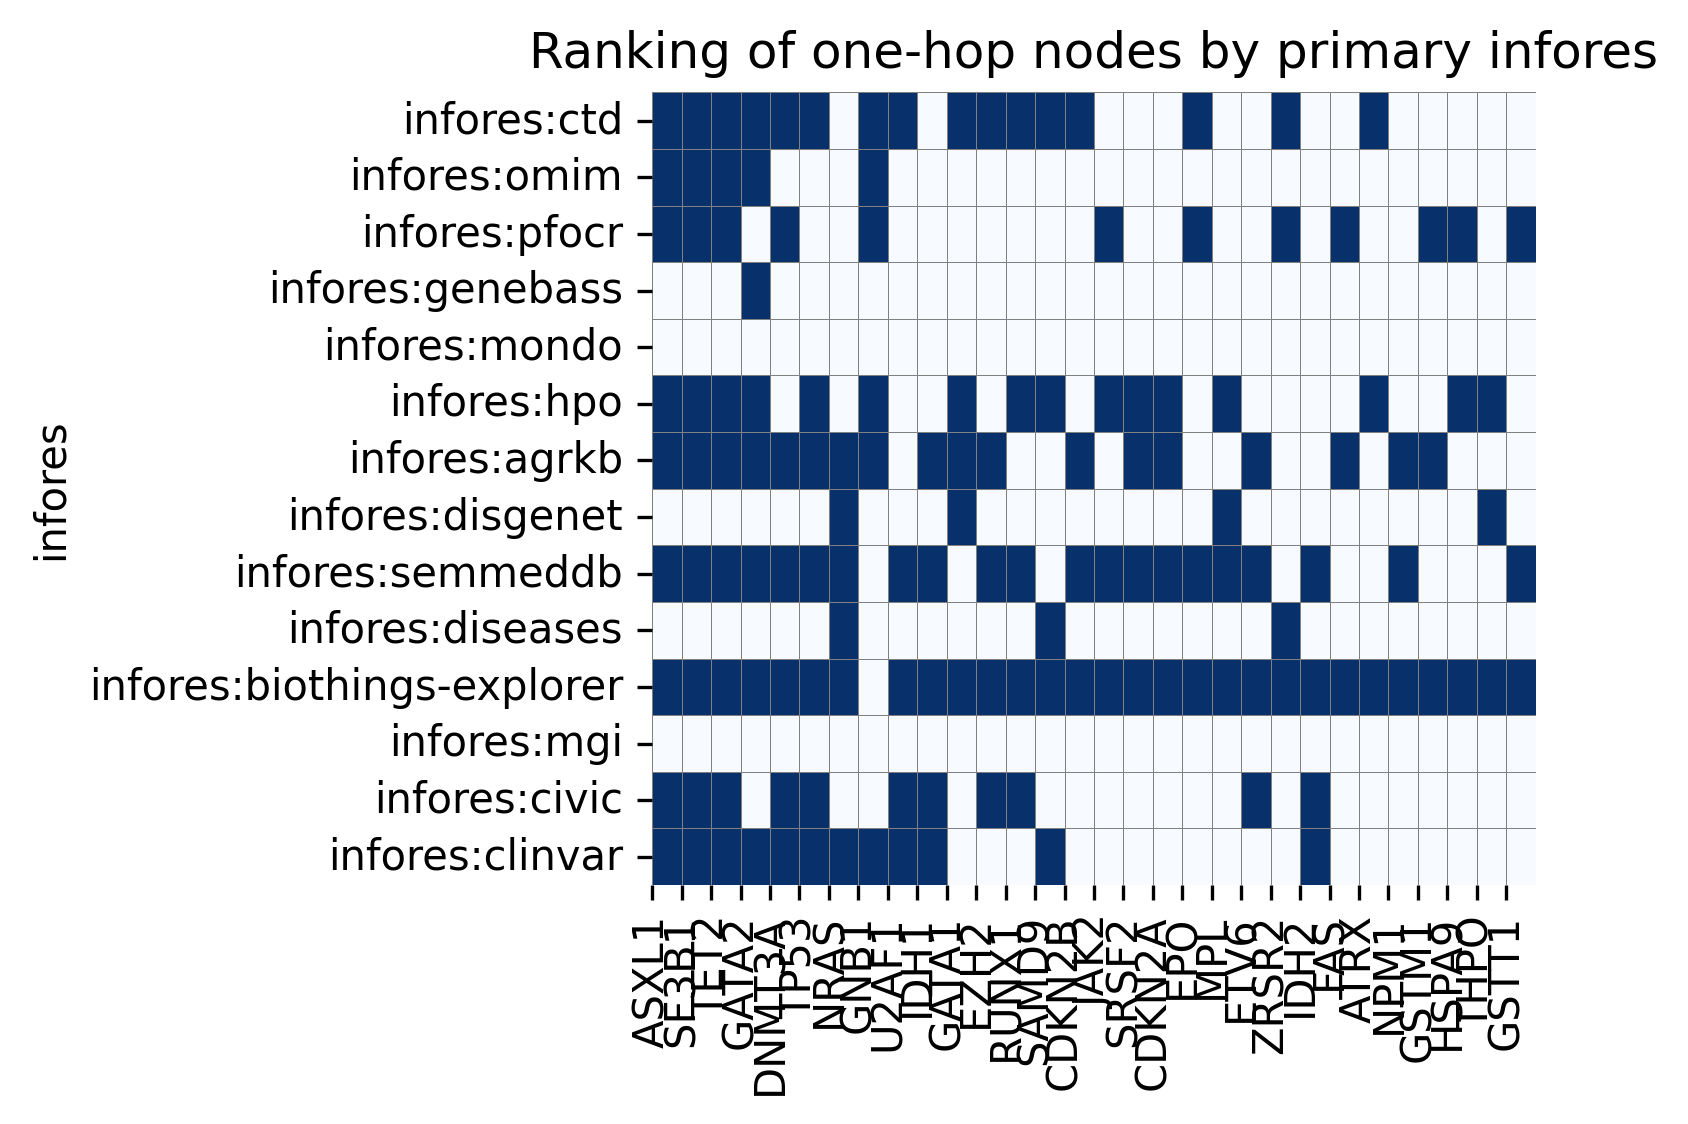

[Text(0.5, 0, 'ASXL1'), Text(2.5, 0, 'TET2'), Text(4.5, 0, 'DNMT3A'), Text(6.5, 0, 'NRAS'), Text(8.5, 0, 'U2AF1'), Text(10.5, 0, 'GATA1'), Text(12.5, 0, 'RUNX1'), Text(14.5, 0, 'CDKN2B'), Text(16.5, 0, 'SRSF2'), Text(18.5, 0, 'EPO'), Text(20.5, 0, 'ETV6'), Text(22.5, 0, 'IDH2'), Text(24.5, 0, 'ATRX'), Text(26.5, 0, 'GSTM1'), Text(28.5, 0, 'THPO')]


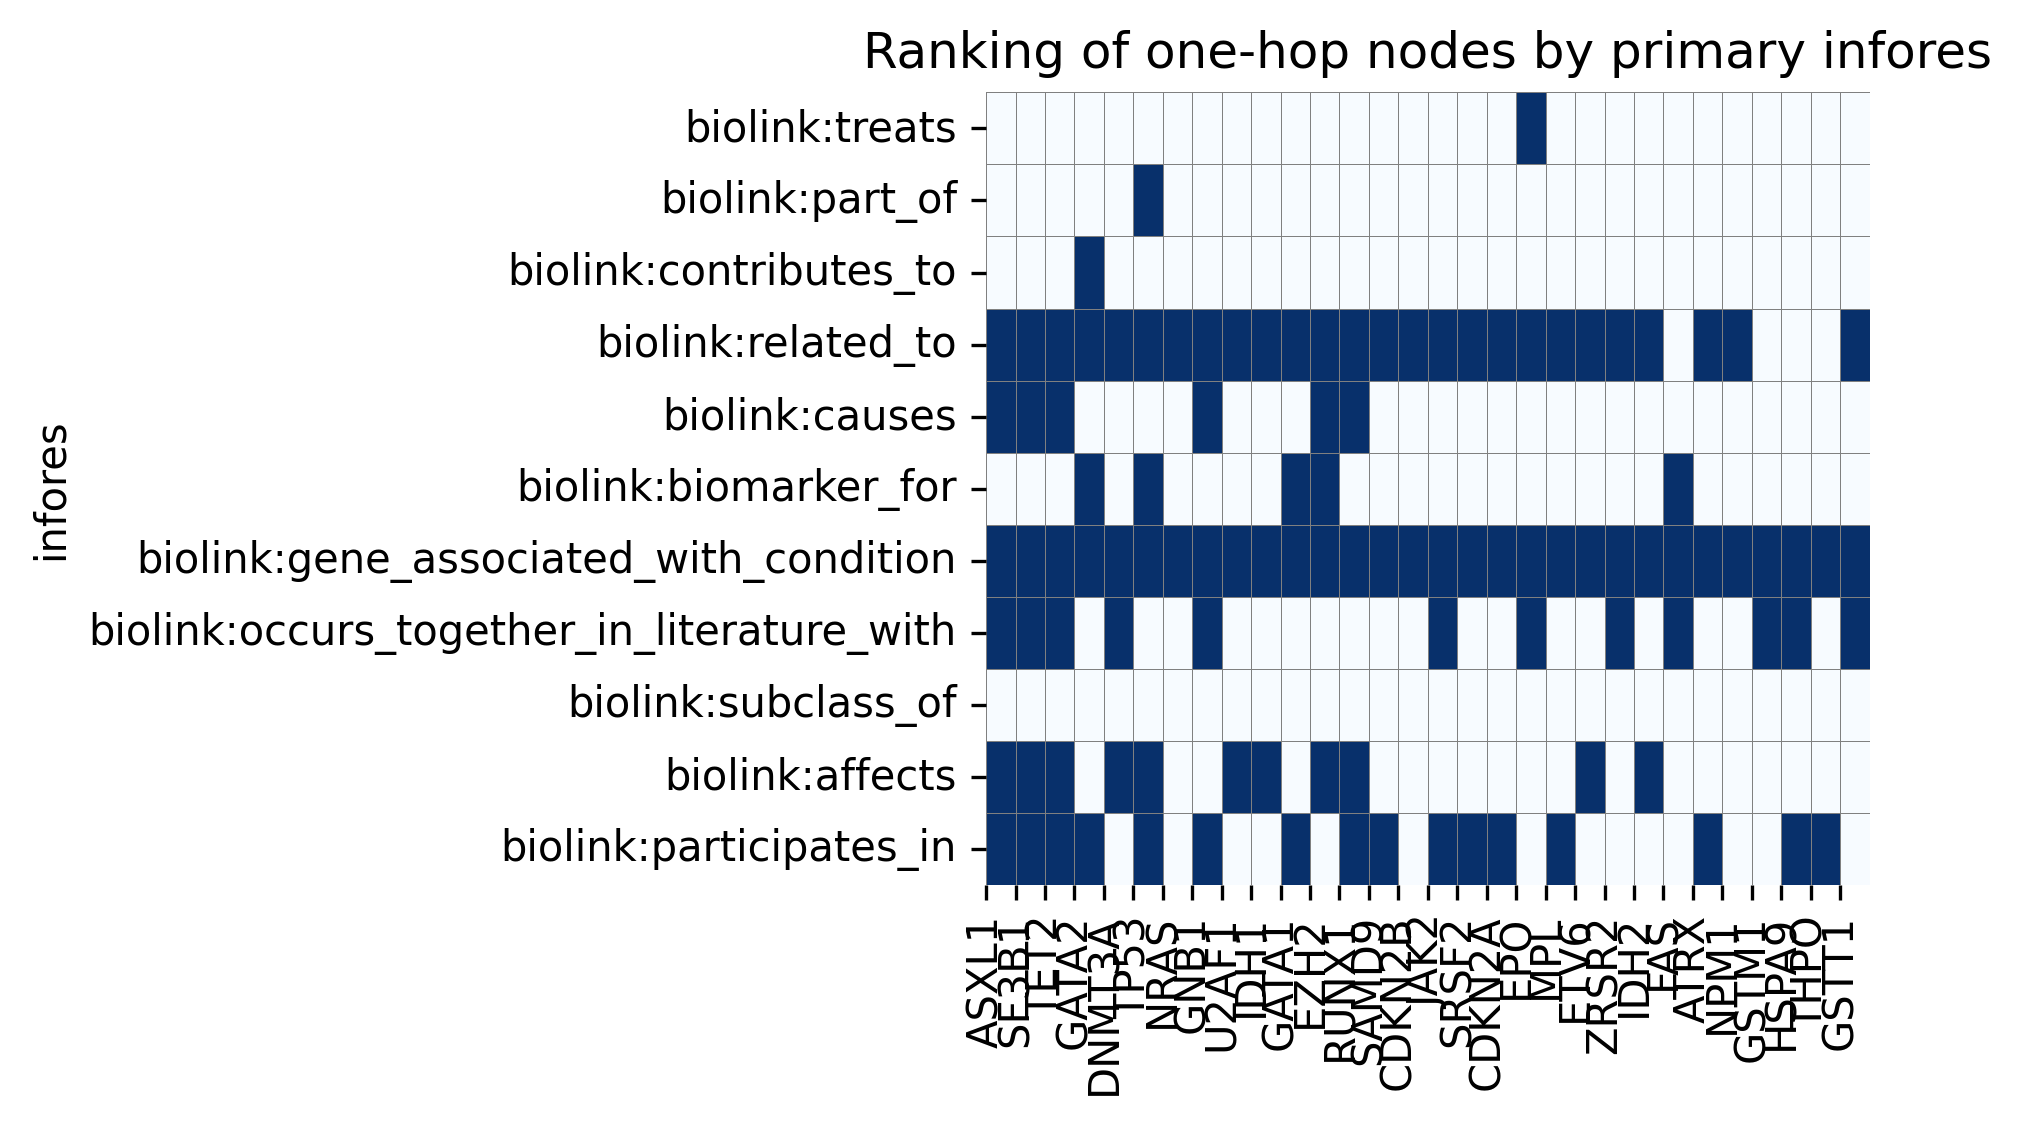

,ASXL1,SF3B1,TET2,GATA2,DNMT3A,TP53,NRAS,GNB1,U2AF1,IDH1,...,IL12B,TTN,THOP1,SPARC,ATXN1,RARS1,TRPM1,KITLG,IRF1,COX1
biolink:treats,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:part_of,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:contributes_to,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:related_to,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
biolink:causes,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:biomarker_for,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:gene_associated_with_condition,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
biolink:occurs_together_in_literature_with,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:subclass_of,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:affects,1,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 30, input_query = input_node1_id, 
                                fontsize = 8)